In [1]:
# %% Load libraries + pretrained VAE
import torch
from diffusers.models import AutoencoderKL
import numpy as np
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# add main folder to working directory
wd = Path.cwd().parent
sys.path.append(str(wd))

from src.data.impasto_datamodule import IMPASTO_DataModule
from src.data.components.transforms import *
from notebooks.preprocess_latent_space.dataset import create_h5f_enc, append_h5f_enc

/home/lmohle/.conda/envs/VanGogh/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def encode_decode(vae, rgb, height, device="cpu"):
    """
    Encodes and subsequently decodes rgb and height images with given pre-trained vae

    Args:
        vae (AutoEncoderKL): pre-trained vae
        rgb (Tensor) : Tensor containing rgb images [N,3,h,w]
        height (Tensor): Tensor containing height images [N,1,h,w]

    Returns:
        recon_rgb (Tensor) : Tensor containing recontructed rgb images [N,3,h,w]
        recon_height (Tensor): Tensor containing reconstructed height images [N,1,h,w]
    """
    vae.to(device)
    with torch.no_grad():
        # Encode
        enc_rgb, enc_height = encode(vae, rgb, height, device) 
        print(enc_rgb[0,0])
        # Decode
        recon_rgb, recon_height = decode(vae, enc_rgb, enc_height, device)
    
    return recon_rgb.cpu(), recon_height.cpu()

def encode(vae, rgb, height, device="cpu"):
    """
    Encodes rgb and height images with given pre-trained vae

    Args:
        vae (AutoEncoderKL): pre-trained vae
        rgb (Tensor) : Tensor containing rgb images [N,3,h,w]
        height (Tensor): Tensor containing height images [N,1,h,w]

    Returns:
        enc_rgb (Tensor) : Tensor containing encoded rgb images [N,4,h/8,w/8]
        enc_height (Tensor): Tensor containing encoded height images [N,4,h/8,w/8]
    """
    # Duplicate height channel to fit the vae
    height = torch.cat((height,height,height), dim=1)
    
    vae.to(device)

    # Encode
    with torch.no_grad():
        enc_rgb     = vae.encode(rgb.to(device)).latent_dist.sample().mul_(0.18215)
        enc_height  = vae.encode(height.to(device)).latent_dist.sample().mul_(0.18215)

    return enc_rgb, enc_height

def decode(vae, enc_rgb, enc_height, device="cpu"):
    """
    Decodes rgb and height images with given pre-trained vae

    Args:
        vae (AutoEncoderKL): pre-trained vae
        enc_rgb (Tensor) : Tensor containing encoded rgb images [N,4,h/8,w/8]
        enc_height (Tensor): Tensor containing encoded height images [N,4,h/8,w/8]

    Returns:
        rgb (Tensor) : Tensor containing rgb images [N,3,h,w]
        height (Tensor): Tensor containing height images [N,1,h,w]
    """
    vae.to(device)
    
    # Decode
    with torch.no_grad():
        recon_rgb      = vae.decode(enc_rgb.to(device)/0.18215).sample
        recon_height   = vae.decode(enc_height.to(device)/0.18215).sample[:,0].unsqueeze(1)

    return recon_rgb.cpu(), recon_height.cpu()

def undo_norm(x):
    x = (x + 1.) / 2.
    x = x.clamp(0., 1.)
    return x

In [3]:
device = "cuda" 
model_dir = r"/data/storage_crack_detection/Pretrained_models/AutoEncoderKL"

with torch.no_grad():
    vae =  AutoencoderKL.from_pretrained(model_dir, local_files_only=True).to(device)

# %% Load the data
lightning_data = IMPASTO_DataModule(data_dir = r"/data/storage_crack_detection/lightning-hydra-template/data/impasto",
                                    variant="Enc_mix_512x512",
                                    crack="synthetic",
                                    batch_size = 4,
                                    # rgb_transform = diffuser_normalize(),
                                    # height_transform = diffuser_normalize_height_idv()
                                    )
lightning_data.setup()

train_loader = lightning_data.train_dataloader()
val_loader = lightning_data.val_dataloader()
test_loader = lightning_data.test_dataloader()

img_dir = "/data/storage_crack_detection/lightning-hydra-template/notebooks/images"

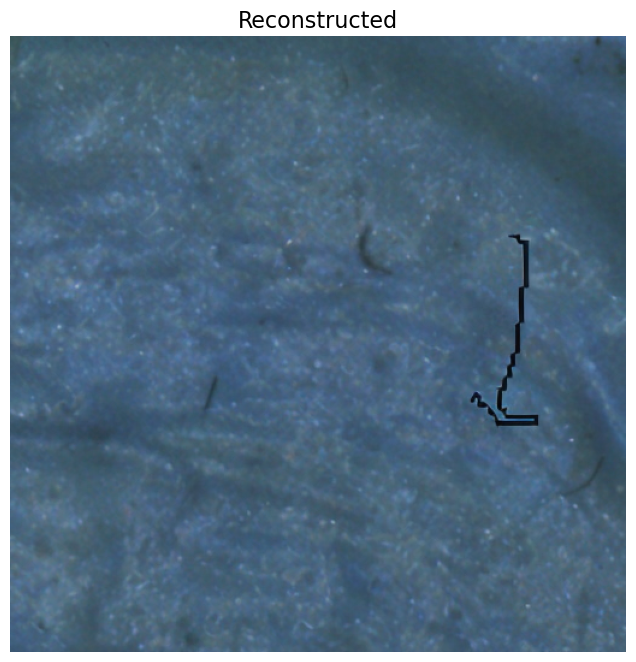

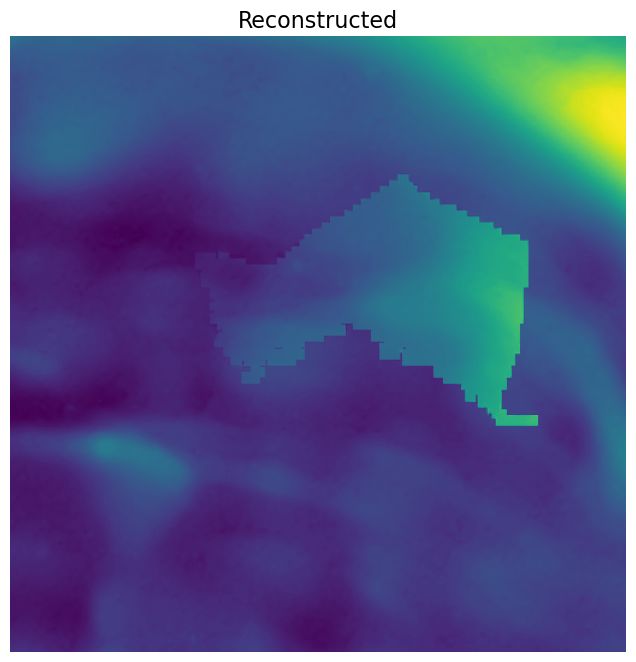

In [5]:
for rgb, height, _ in test_loader:
    recon_rgb, recon_height = decode(vae, rgb.float(), height.float(), device)
    
    recon_rgb = undo_norm(recon_rgb)
    recon_height = undo_norm(recon_height)
    break
i = 2
fig, axes = plt.subplots(1, 1, figsize=(12,8))

axes.imshow(recon_rgb[i].permute(1,2,0))
axes.set_title(f"Reconstructed", fontsize=16)
axes.axis('off')

plt.show()
# plt_dir = os.path.join(img_dir, "test_rgb")
# fig.savefig(plt_dir)
# plt.close()

# %% Plot results height

i = 2
fig, axes = plt.subplots(1, 1, figsize=(12,8))

axes.imshow(recon_height[i,0])
axes.set_title(f"Reconstructed", fontsize=16)
axes.axis('off')

plt.show()
# plt_dir = os.path.join(img_dir, "test_height")
# fig.savefig(plt_dir)
# plt.close()

In [22]:
for rgb, height, _ in train_loader:
    recon_rgb, recon_height = encode_decode(vae, rgb, height, device)
    
    recon_rgb = undo_norm(recon_rgb)
    recon_height = undo_norm(recon_height)
    break

rgb2 = undo_norm(rgb)

i = 3
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(rgb2[i].permute(1,2,0))
axes[0].set_title(f"Original mini patch", fontsize=16)
axes[0].axis('off')

axes[1].imshow(recon_rgb[i].permute(1,2,0))
axes[1].set_title(f"Reconstructed", fontsize=16)
axes[1].axis('off')

plt_dir = os.path.join(img_dir, "test_rgb")
fig.savefig(plt_dir)
plt.close()

# %% Plot results height

height2 = undo_norm(height)

i, j = 3, 2
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(height2[i,0])
axes[0].set_title(f"Original mini patch", fontsize=16)
axes[0].axis('off')

axes[1].imshow(recon_height[i,0])
axes[1].set_title(f"Reconstructed", fontsize=16)
axes[1].axis('off')

plt_dir = os.path.join(img_dir, "test_height")
fig.savefig(plt_dir)
plt.close()

tensor([[-0.7102,  0.4488, -0.3976,  ..., -0.0192, -0.4177,  0.3808],
        [-0.2887,  0.5939,  0.3629,  ..., -0.0812,  1.4219,  0.2618],
        [-0.9263, -1.3043,  0.0407,  ...,  0.8395,  0.7980,  0.0671],
        ...,
        [-0.0964,  0.1365, -0.0467,  ...,  0.4752,  1.0161,  0.5350],
        [ 0.2227,  0.5882,  0.3666,  ...,  0.6626,  0.0171,  1.9526],
        [-0.0794, -0.0027,  0.4733,  ...,  0.5801,  0.1038, -0.0099]],
       device='cuda:0')
